In [1]:
import os,sys
sys.path.append(os.path.abspath("../"))
import healpy as h
import collections
from modules.calc_EB_rec_noise.fast_calc_eb_rec_noise import calc_eb_rec_noise
from modules.calc_TB_rec_noise.fast_calc_tb_rec_noise import calc_tb_rec_noise
from modules import eb_rec
from modules import tb_rec

from astropy.io import fits
figpath="../results/planck143_rerun/"

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
ensure_dir(figpath)

# jpegpath=figpath + "/jpeg/" ; ensure_dir(jpegpath)
datapath=figpath + "/data_143/" ; ensure_dir(datapath)

def return_Nl(fwhm,noise_rms,lmax):
    ell=np.arange(lmax+1)
    noise_rms=noise_rms*(1./60.)*(np.pi/180.)
    thetab=((fwhm/60.)*np.pi/180.)/np.sqrt(8.*np.log(2))
    Bl=exp(thetab**2 *(ell*(ell+1))/2)
    return ell,noise_rms**2. * Bl**2.

%pylab notebook

Populating the interactive namespace from numpy and matplotlib


# Theory power spectra

<IPython.core.display.Javascript object>


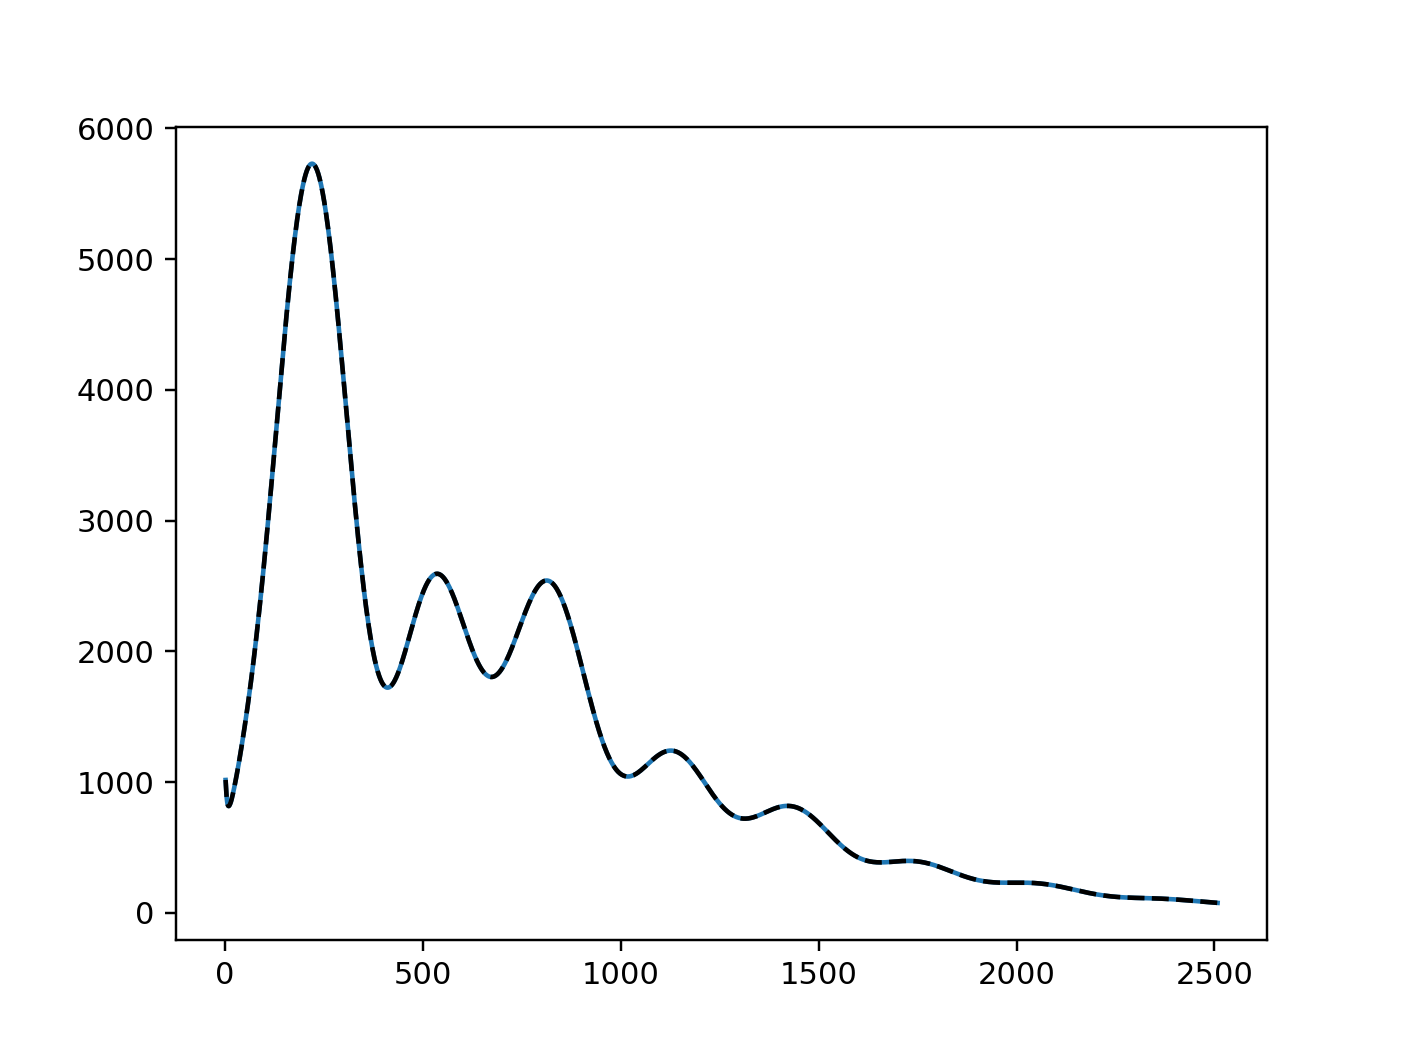

<IPython.core.display.Javascript object>


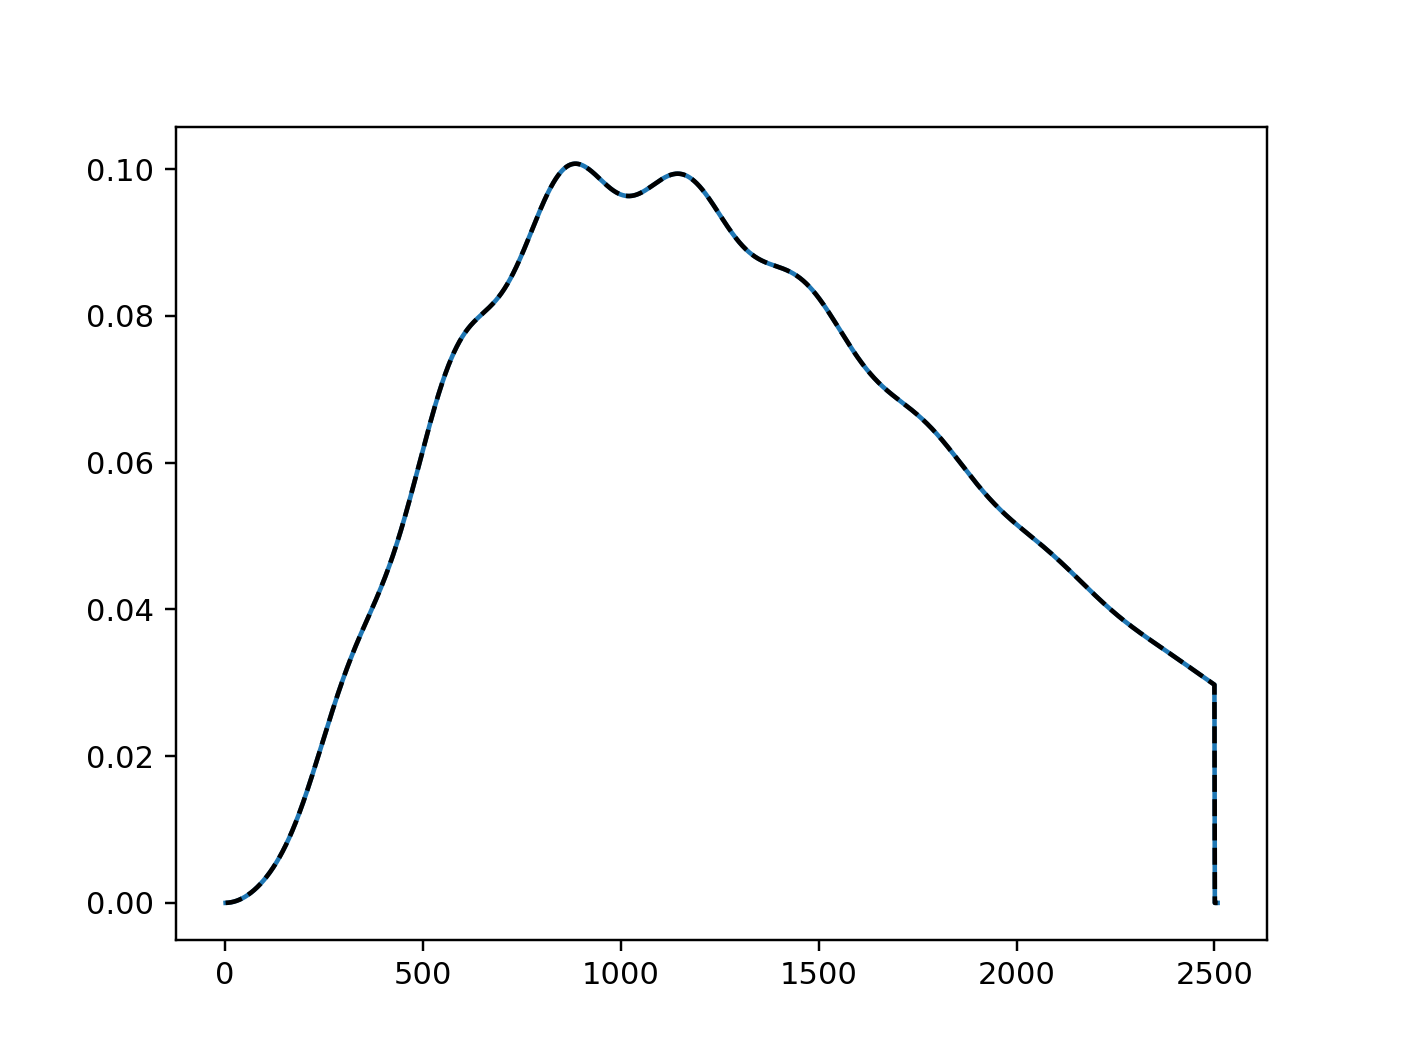

In [2]:
nside=1024
lmax=1536
lpad=256
lmin=2
Lmax=512

# clthry=np.loadtxt("../T2P_leakage/planck_2015_cmb/planck_2015_cmb_totCls.dat")
# clthry=np.loadtxt("../T2P_leakage/planck_2015_cmb/planck_2015_cmb_lensedtotCls.dat")

# maxell=3500
# ell=clthry[:maxell+1,0] ; fl=ell*(ell+1)/(2.*pi)
# cltt=clthry[:maxell+1,1]/fl ; cltt=append([0.,0.],cltt)
# clee=clthry[:maxell+1,2]/fl ; clee=append([0.,0.],clee)
# clbb=clthry[:maxell+1,3]/fl ; clbb=append([0.,0.],clbb)
# clte=clthry[:maxell+1,4]/fl ; clte=append([0.,0.],clte)
# ell=append([0.,1,],ell) ; fl=ell*(ell+1)/(2.*pi)
# clthr=[cltt,clee,clbb,clte]

clthry=np.loadtxt("../planck_cmb_cl/cmb_cl.txt")

maxell=2048
ell=clthry[:maxell+1,0] ; fl=ell*(ell+1)/(2.*pi)
cltt=clthry[:maxell+1,1]/fl ; cltt=append([0.,0.],cltt)
clte=clthry[:maxell+1,2]/fl ; clte=append([0.,0.],clte)
clee=clthry[:maxell+1,3]/fl ; clee=append([0.,0.],clee)
clbb=clthry[:maxell+1,4]/fl ; clbb=append([0.,0.],clbb)
ell=append([0.,1,],ell) ; fl=ell*(ell+1)/(2.*pi)
clthr=[cltt,clee,clbb,clte]


clthry_new=np.loadtxt("../planck_cmb_cl/COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt")

ell=clthry_new[:maxell+1,0] ; fl=ell*(ell+1)/(2.*pi)
cltt_new=clthry_new[:maxell+1,1]/fl ; cltt_new=append([0.,0.],cltt_new)
clte_new=clthry_new[:maxell+1,2]/fl ; clte_new=append([0.,0.],clte_new)
clee_new=clthry_new[:maxell+1,3]/fl ; clee_new=append([0.,0.],clee_new)
clbb_new=clthry_new[:maxell+1,4]/fl ; clbb_new=append([0.,0.],clbb_new)
ell=append([0.,1,],ell) ; fl=ell*(ell+1)/(2.*pi)
clthr_new=[cltt_new,clee_new,clbb_new,clte_new]

figure()
plot(clthry[:,0],clthry[:,1])
plot(clthry_new[:,0],clthry_new[:,1],"k--")

figure()
plot(clthry[:,0],clthry[:,4])
plot(clthry_new[:,0],clthry_new[:,4],"k--")

# Mask and beam

In [3]:
ell=np.arange(lmax+1)
beamfile="/Users/adityarotti/Documents/Work/Data/Planck/maps/HFI_RIMO_Beams-075pc_R2.00.fits"
f=fits.open(beamfile)
bl143=f[4].data[0][0][:lmax+lpad+1]
bp=np.ones_like(bl143)
f.close()

maskname="/Users/adityarotti/Documents/Work/Data/Planck/masks/HFI_Mask_GalPlane-apo2_2048_R2.00.fits"
# maskname="/Users/adityarotti/Documents/Work/Data/Planck/masks/HFI_Mask_GalPlane-apo0_2048_R2.00.fits"
# mask72=h.read_map(maskname,4,dtype=np.float64,verbose=False)
# mask72=h.ud_grade(mask72,nside)
# fsky72=sum(mask72)/size(mask72)
# print(fsky72)
mask62=h.read_map(maskname,3,dtype=np.float64,verbose=False)
mask62=h.ud_grade(mask62,nside)
fsky62=sum(mask62)/size(mask62)
print(fsky62)
mask52=h.read_map(maskname,2,dtype=np.float64,verbose=False)
mask52=h.ud_grade(mask52,nside)
fsky52=sum(mask52)/size(mask52)
print(fsky52)

maskname="/Users/adityarotti/Documents/Work/Data/Planck/masks/COM_Mask_CMB-common-Mask-Pol_2048_R3.00.fits"
mask78=h.read_map(maskname,dtype=np.float64,verbose=False)
mask78=h.ud_grade(mask78,nside)
fsky78=sum(mask78)/size(mask78)

/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


0.6206998258265879
0.5188073411715821


<IPython.core.display.Javascript object>


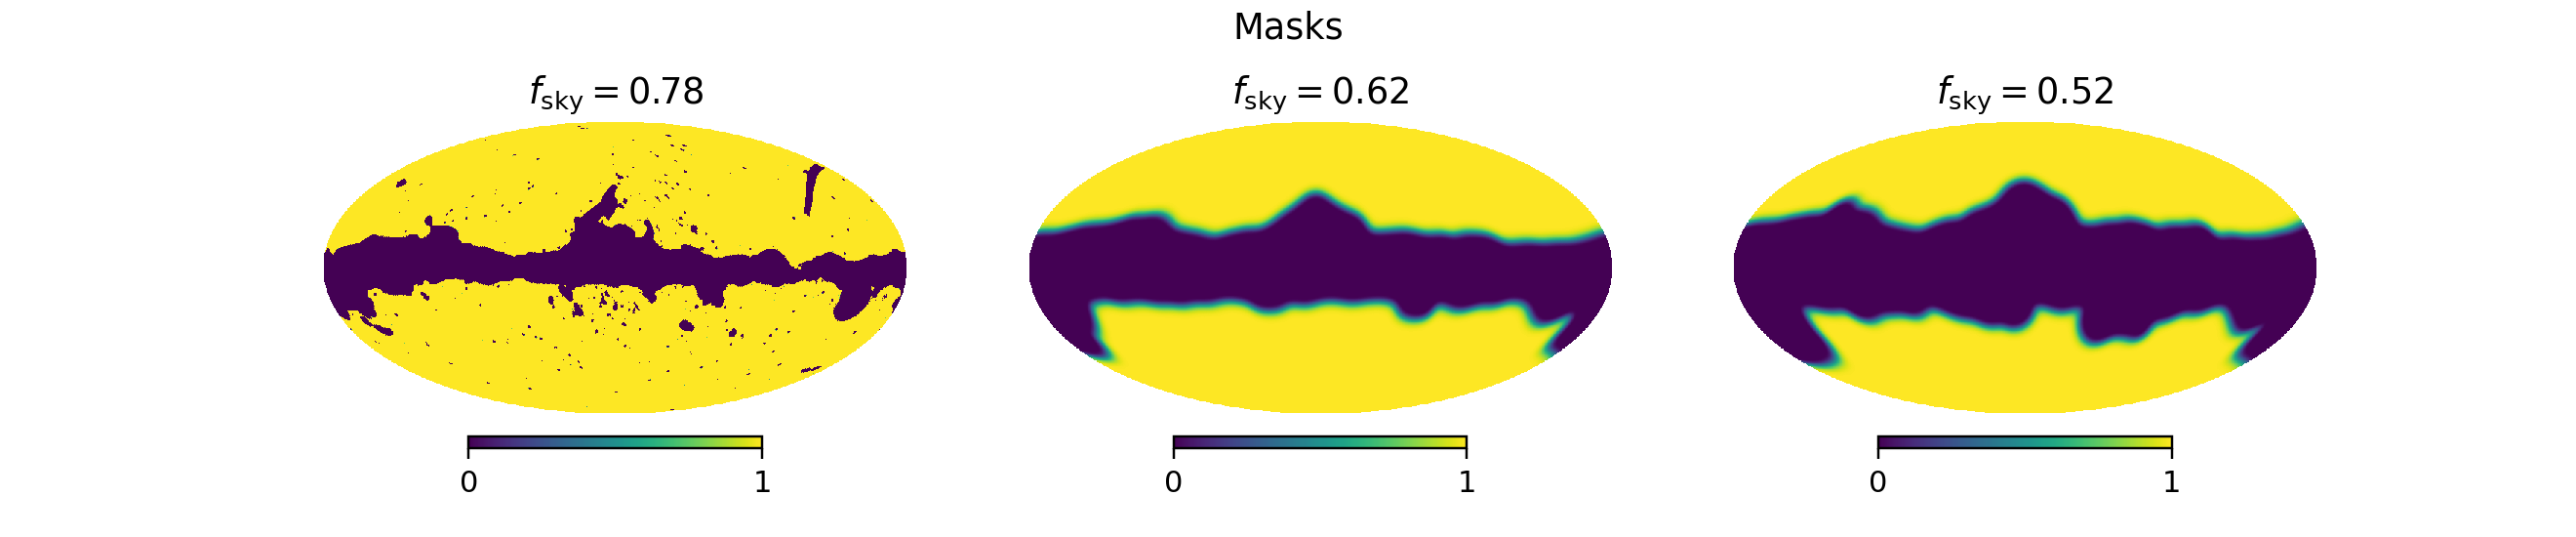

/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This

In [4]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3,figsize=[12,2.5])
axes(ax1)
# h.mollview(mask72,title=r"$f_{\rm sky}=$" + str(round(fsky72,2)),hold=True)
h.mollview(mask78,title=r"$f_{\rm sky}=$" + str(round(fsky78,2)),hold=True)
axes(ax2)
h.mollview(mask62,title=r"$f_{\rm sky}=$" + str(round(fsky62,2)),hold=True)
axes(ax3)
h.mollview(mask52,title=r"$f_{\rm sky}=$" + str(round(fsky52,2)),hold=True)
suptitle(r"Masks")
figname=figpath + "masks.pdf"
savefig(figname,bbox_inches="tight",dpi=300)

In [8]:
fwhm143=7.22 #arcminutes
blthry=h.gauss_beam(fwhm=(fwhm143/60.)*np.pi/180.)
Trms=0.55 # uK-deg
Prms=1.17 # uK-deg

ell,Nl_T=return_Nl(fwhm143,Trms*60.,lmax)
ell,Nl_P=return_Nl(fwhm143,Prms*60.,lmax)
Nl_thry=[Nl_T,Nl_P,Nl_P,Nl_P*0.]

# Read in data

In [9]:
# fname143="/Users/adityarotti/Documents/Work/Data/Planck/maps/COM_SimMap_sky-ffp8-nobpm-143_2048_R2.00_full.fits"

fname143="/Users/adityarotti/Documents/Work/Data/Planck/maps/HFI_SkyMap_143-field-IQU_2048_R3.00_full.fits"
tqu=h.read_map(fname143,(0,1,2),dtype=np.float64,verbose=False)*1e6

In [10]:
# # Removing bad pixels
# x=tqu[0] ; x[x<-1e-6]=0. ; tqu[0]=x
# x=tqu[1] ; x[x<-1e-6]=0. ; tqu[1]=x
# x=tqu[2] ; x[x<-1e-6]=0. ; tqu[2]=x

In [11]:
# Deconvolve then mask
alm=h.map2alm(tqu,pol=True,lmax=lmax+lpad)
alm[0]=h.almxfl(alm[0],fl=1./bl143)
alm[1]=h.almxfl(alm[1],fl=1./bl143)
alm[2]=h.almxfl(alm[2],fl=1./bl143)
dec_tqu=h.alm2map(alm,pol=True,nside=nside)
alm=h.map2alm(dec_tqu*mask78,pol=True,lmax=lmax)

## Spectra plots

In [ ]:
clobs=h.alm2cl(alm)/fsky78

ell=np.arange(lmax+1)
fl=ell*(ell+1)/(2.*pi)

cmp_list=["TT","EE","BB","TE"]

for idx in range(4):
    figure()
    plot(ell[2:],fl[2:]*clthr[idx][2:lmax+1],label="Theory signal")
    plot(ell[2:],fl[2:]*Nl_thry[idx][2:],label="Theory noise")
#     plot(ell[2:],fl[2:]*clobs[idx][2:],label="Observed")
    plot(ell[2:],fl[2:]*clobs[idx][2:],"--",label=r"Observed DM $f_{\rm sky}=$" +str(round(fsky52,2)))
    
    
    plot(ell[2:],fl[2:]*(clthr[idx][2:lmax+1] + Nl_thry[idx][2:]),"k-.",label="Theory total")
    xlabel(r"multipole $\ell$",fontsize=12)
    ylabel(r"$\ell(\ell+1)C_{\ell}^{" + cmp_list[idx] + "}/2 \pi$ $\mu K ^2$",fontsize=12)
    if idx!=0 and idx!=3:
        loglog()
    legend(loc=0)
    grid(which="both",linestyle="dashed",alpha=0.2)
    filename=figpath + cmp_list[idx] + "_spectrum.pdf"
    savefig(filename,bbox_inches="tight")

# Birefringence reconstruction studies

<IPython.core.display.Javascript object>


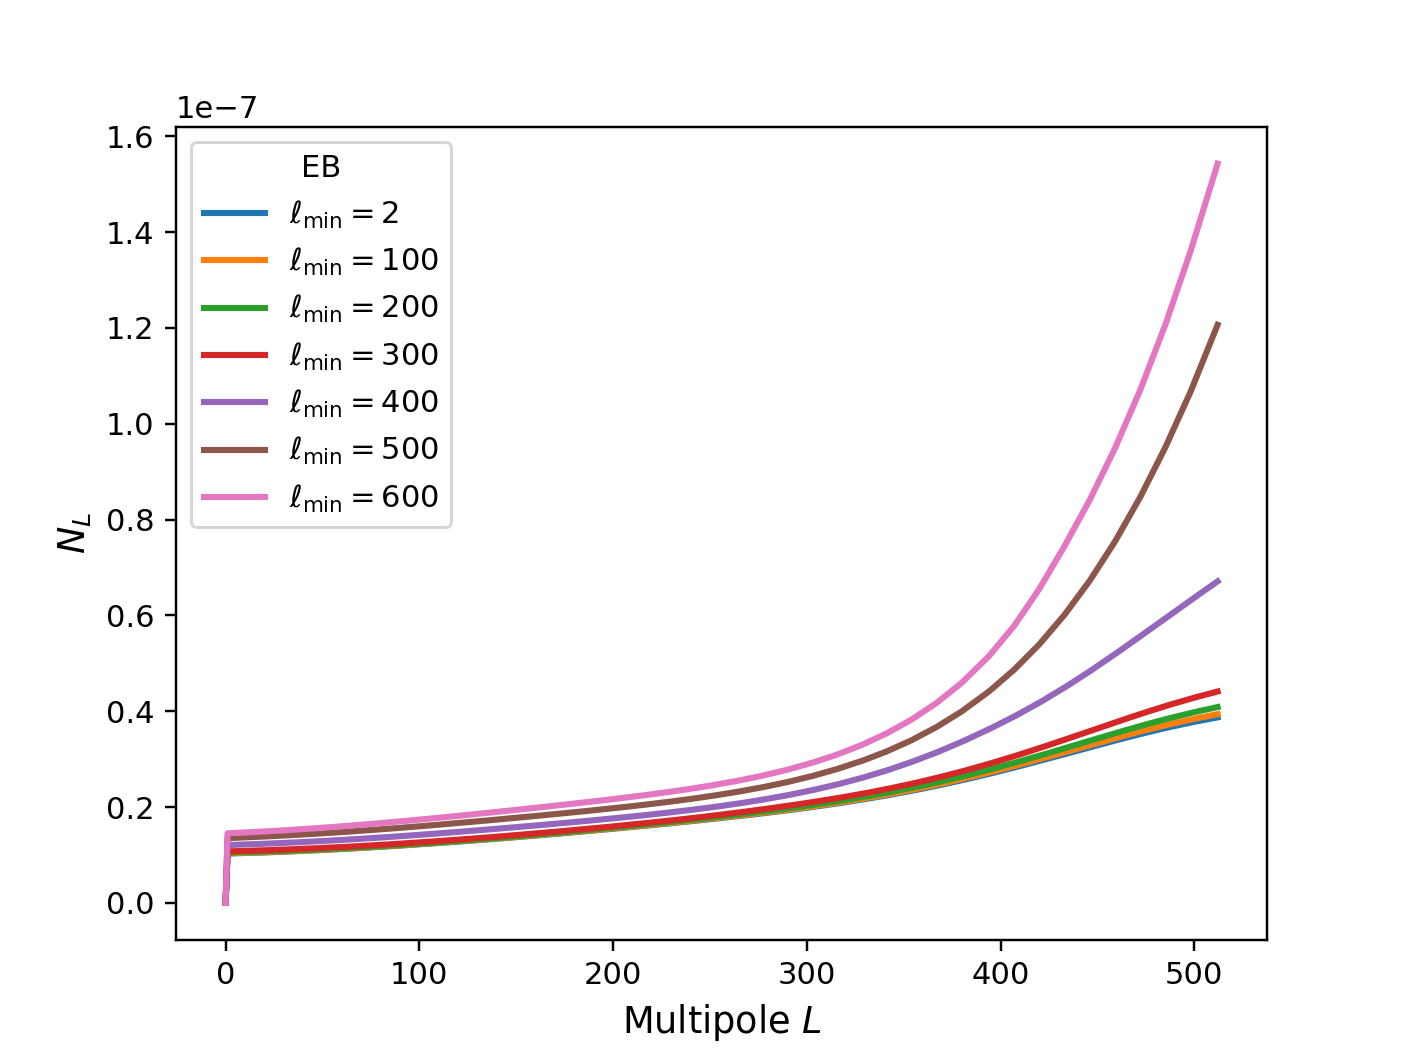

<IPython.core.display.Javascript object>


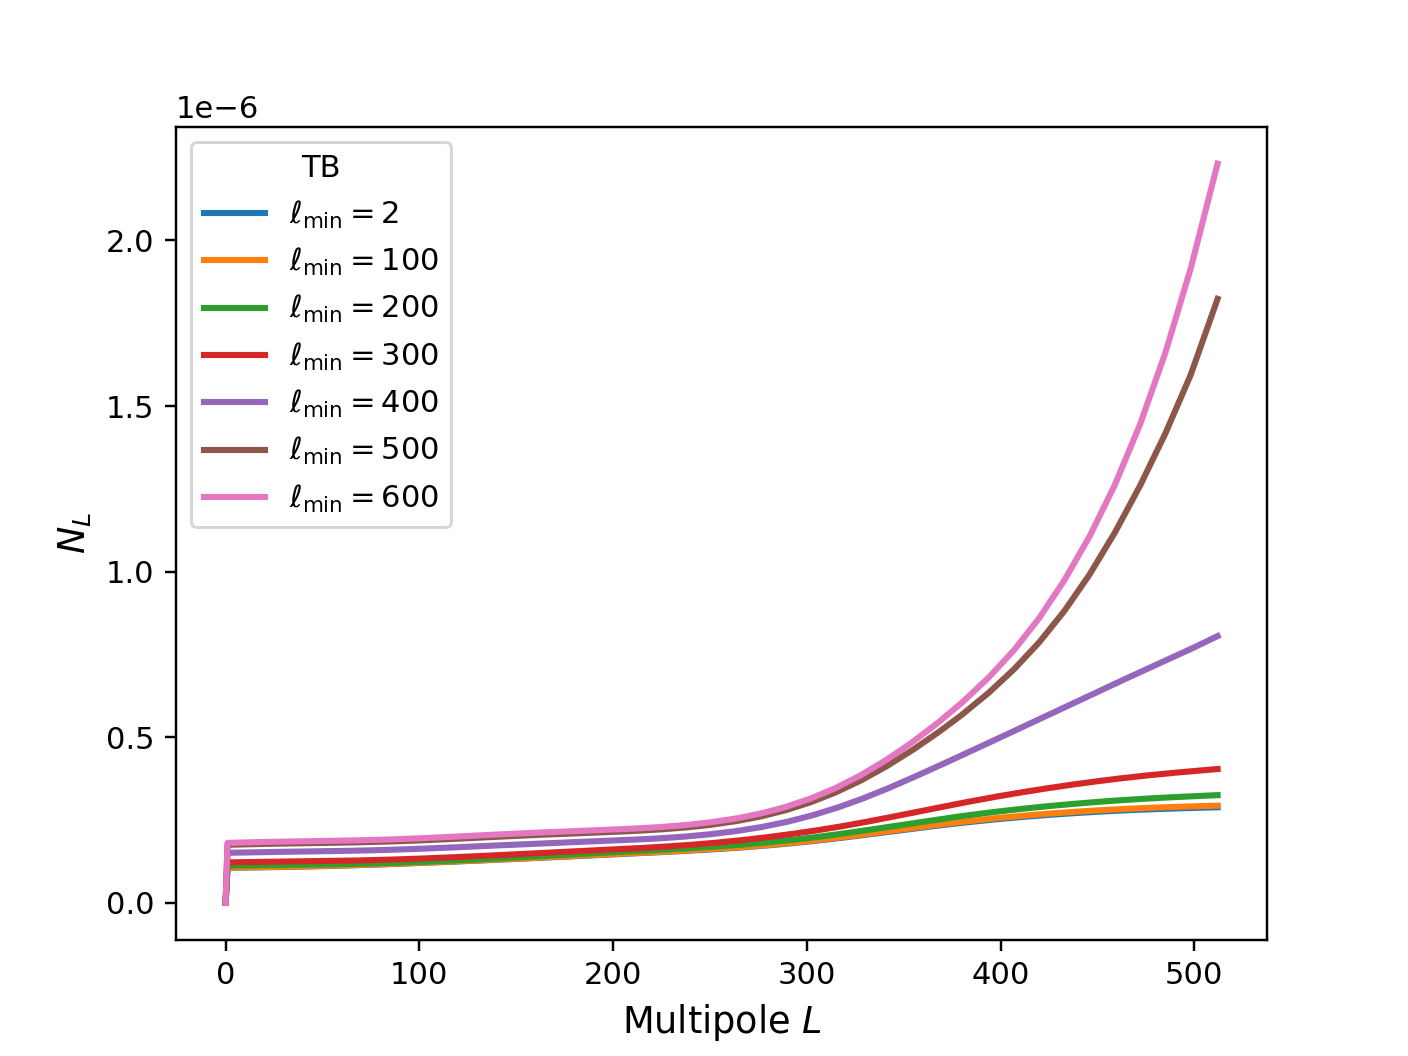

In [120]:
L=np.arange(Lmax+1)
figure()
for temp_lmin in [2,100,200,300,400,500,600]:
    NLeb=calc_eb_rec_noise(clthr[1],clthr[1],clthr[2],temp_lmin,lmax,Lmax)
    plot(L,NLeb,"-",lw=2,label=r"$\ell_{\rm min}=$" + str(temp_lmin))
xlabel("Multipole $L$",fontsize=12)
ylabel("$N_L$",fontsize=12)
legend(loc=0,title="EB")
figname=figpath + "eb_recnoise_fn_of_lmin.pdf"
savefig(figname,bbox_inches="tight")

figure()
for temp_lmin in [2,100,200,300,400,500,600]:
    NLtb=calc_tb_rec_noise(clthr[3],clthr[0],clthr[2],temp_lmin,lmax,Lmax)
    plot(L,NLtb,"-",lw=2,label=r"$\ell_{\rm min}=$" + str(temp_lmin))
xlabel("Multipole $L$",fontsize=12)
ylabel("$N_L$",fontsize=12)
legend(loc=0,title="TB")
figname=figpath + "tb_recnoise_fn_of_lmin.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


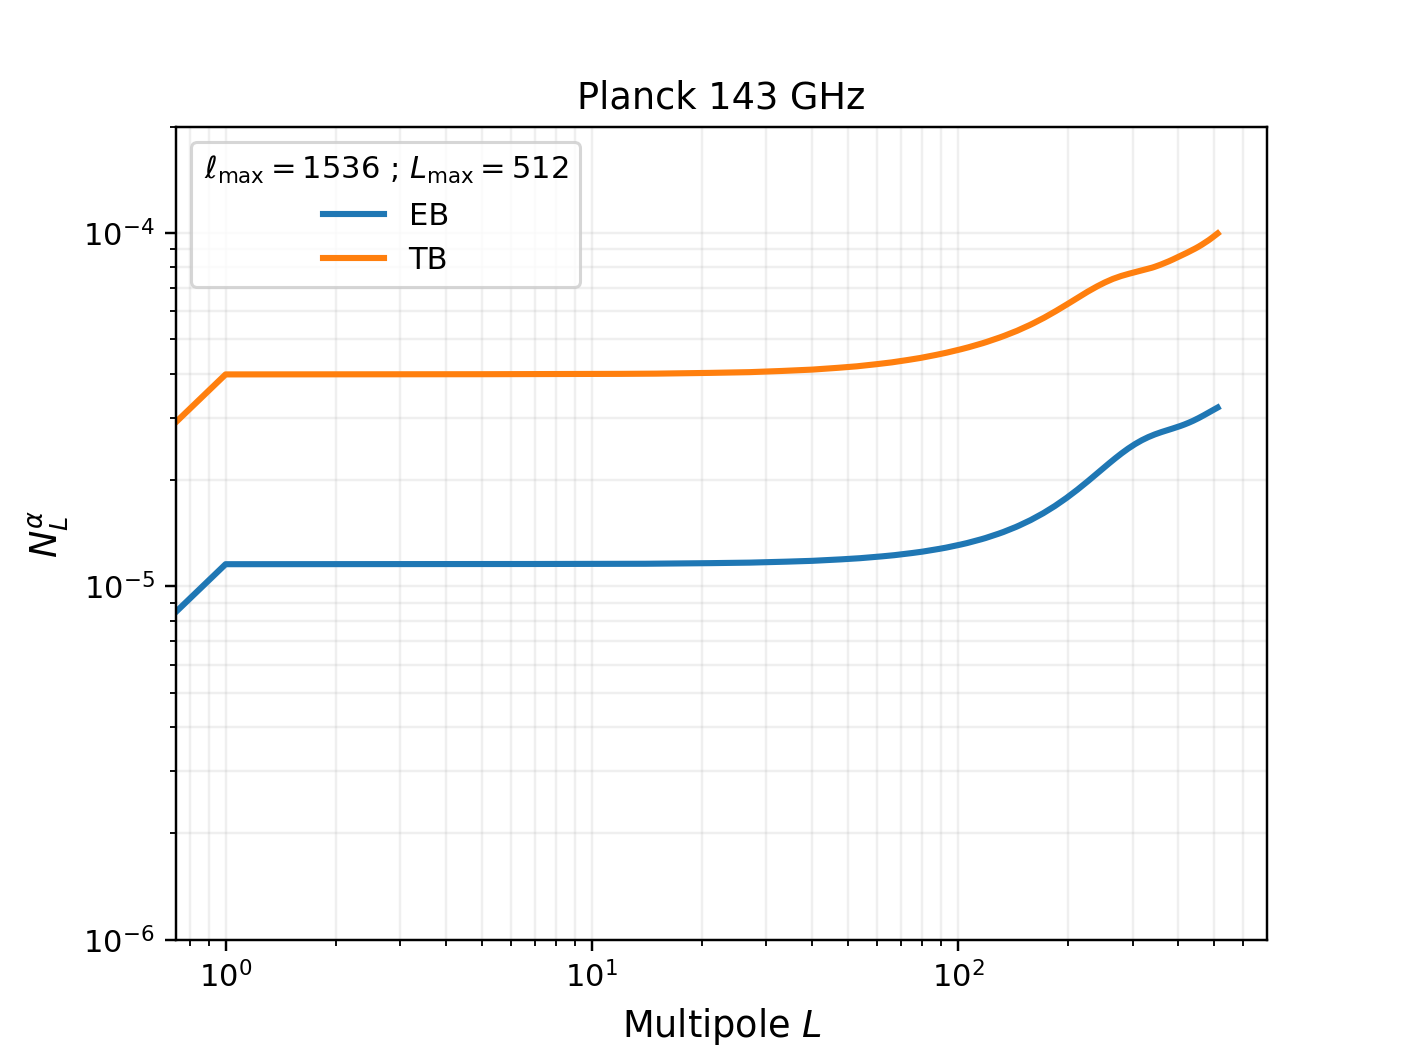

In [148]:
L=np.arange(Lmax+1)
NLeb=calc_eb_rec_noise(clthr[1],clobs[1],clobs[2],lmin,lmax,Lmax)
NLtb=calc_tb_rec_noise(clthr[3],clobs[0],clobs[2],lmin,lmax,Lmax)

figure()
plot(L,NLeb,"-",lw=2,label="EB")
plot(L,NLtb,"-",lw=2,label="TB")
loglog()
ylabel(r"$N^{\alpha}_L$",fontsize=12)
xlabel(r"Multipole $L$",fontsize=12)
grid(which="both",alpha=0.2,linestyle="solid")
legend(loc="upper left",title=r"$\ell_{\rm max}=$" + str(lmax) + " ; " + r"$L_{\rm max}=$"+str(Lmax) )
title("Planck 143 GHz")
ylim(1e-6,2e-4)
# figname=figpath + "eb_vs_tb_recnoise_lmin" + str(lmin) + "_lmax" + str(lmax) + "_Lmax" + str(Lmax) + ".pdf"
figname=figpath + "eb_vs_tb_recnoise_lmin" + str(lmin) + "_lmax" + str(lmax) + "_Lmax" + str(Lmax) + ".jpeg"
savefig(figname,bbox_inches="tight",dpi=250)

In [149]:
# eb1=eb_rec.opt_eb_qe(dec_tqu,clthr,lmax,Lmax,mask=mask52,ellmin=2)
# eb1.eb_reconstruct()

# eb2=eb_rec.opt_eb_qe(dec_tqu,clthr,lmax,Lmax,mask=mask52,ellmin=200)
# eb2.eb_reconstruct()

# figure()
# plot(eb1.Cl_rec_alpha)
# plot(eb1.N_L)

# figure()
# plot(eb2.Cl_rec_alpha)
# plot(eb2.N_L,"k--")

In [150]:
# tb1=tb_rec.opt_tb_qe(dec_tqu,clthr,lmax,Lmax,mask=mask52,ellmin=2)
# tb1.tb_reconstruct()

# tb2=tb_rec.opt_tb_qe(dec_tqu,clthr,lmax,Lmax,mask=mask52,ellmin=200)
# tb2.tb_reconstruct()

# figure()
# plot(tb1.Cl_rec_alpha)
# plot(tb1.N_L)

# figure()
# plot(tb2.Cl_rec_alpha)
# plot(tb2.N_L,"k--")

In [151]:
eb52=eb_rec.opt_eb_qe(dec_tqu,clthr,lmax,Lmax,mask=mask52,ellmin=lmin)
eb52.eb_reconstruct()

eb62=eb_rec.opt_eb_qe(dec_tqu,clthr,lmax,Lmax,mask=mask62,ellmin=lmin)
eb62.eb_reconstruct()

# eb72=eb_rec.opt_eb_qe(dec_tqu,clthr,lmax,Lmax,mask=mask72,ellmin=lmin)
# eb72.eb_reconstruct()

eb78=eb_rec.opt_eb_qe(dec_tqu,clthr,lmax,Lmax,mask=mask78,ellmin=lmin)
eb78.eb_reconstruct()

In [152]:
tb52=tb_rec.opt_tb_qe(dec_tqu,clthr,lmax,Lmax,mask=mask52,ellmin=lmin)
tb52.tb_reconstruct()

tb62=tb_rec.opt_tb_qe(dec_tqu,clthr,lmax,Lmax,mask=mask62,ellmin=lmin)
tb62.tb_reconstruct()

# tb72=tb_rec.opt_tb_qe(dec_tqu,clthr,lmax,Lmax,mask=mask72,ellmin=lmin)
# tb72.tb_reconstruct()

tb78=tb_rec.opt_tb_qe(dec_tqu,clthr,lmax,Lmax,mask=mask78,ellmin=lmin)
tb78.tb_reconstruct()

<IPython.core.display.Javascript object>


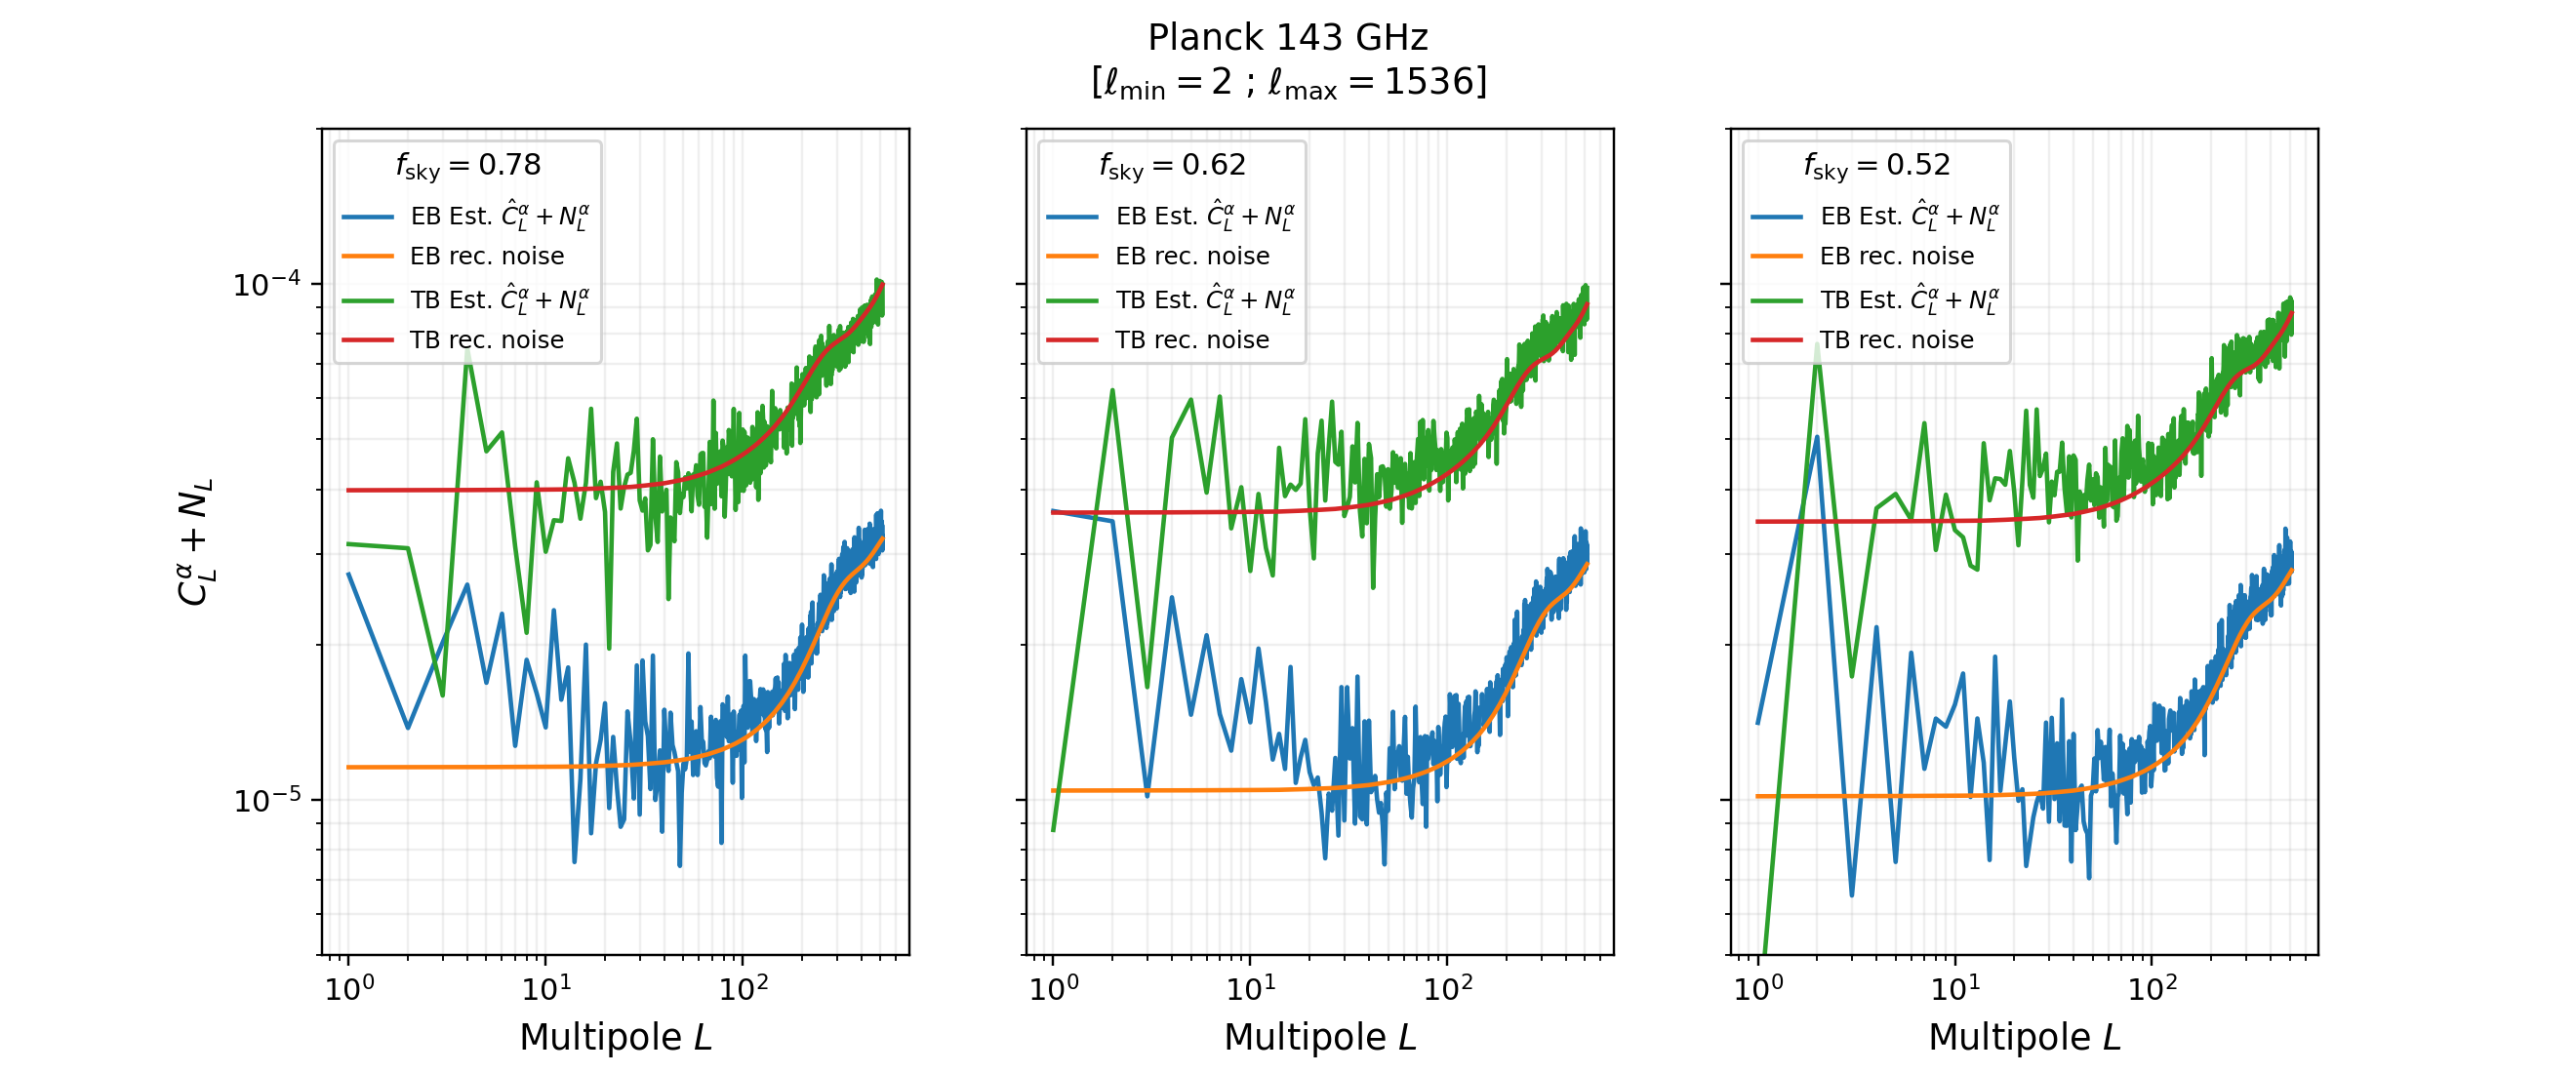

In [153]:
offset=1.
fig,ax=subplots(ncols=3,nrows=1,sharey=True,figsize=[12,5])
L=np.arange(eb52.Lmax+1)
fL=np.ones(eb52.Lmax+1,np.float64)
# ax[0].plot(L[1:],fL[1:]*eb72.Cl_rec_alpha[1:]*offset,label=r"EB Est. $\hat{C}^{\alpha}_{L} + N^{\alpha}_{L}$")
# ax[0].plot(L[1:],fL[1:]*eb72.N_L[1:],label=r"EB rec. noise")
ax[0].plot(L[1:],fL[1:]*eb78.Cl_rec_alpha[1:]*offset,label=r"EB Est. $\hat{C}^{\alpha}_{L} + N^{\alpha}_{L}$")
ax[0].plot(L[1:],fL[1:]*eb78.N_L[1:],label=r"EB rec. noise")
# ax[0].plot(L[1:],fL[1:]*tb72.Cl_rec_alpha[1:]*offset,label=r"TB Est. $\hat{C}^{\alpha}_{L} + N^{\alpha}_{L}$")
# ax[0].plot(L[1:],fL[1:]*tb72.N_L[1:],label=r"TB rec. noise")
ax[0].plot(L[1:],fL[1:]*tb78.Cl_rec_alpha[1:]*offset,label=r"TB Est. $\hat{C}^{\alpha}_{L} + N^{\alpha}_{L}$")
ax[0].plot(L[1:],fL[1:]*tb78.N_L[1:],label=r"TB rec. noise")
ax[0].loglog()
# ax[0].legend(loc="upper left",title=r"$f_{\rm sky}=$" + str(round(fsky72,2)),fontsize=8)
ax[0].legend(loc="upper left",title=r"$f_{\rm sky}=$" + str(round(fsky78,2)),fontsize=8)
ax[0].set_xlabel(r"Multipole $L$",fontsize=12)
ax[0].set_ylabel(r"$C^{\alpha}_L + N_{L}$",fontsize=12)
ax[0].grid(alpha=0.2,which="both")
ax[0].set_ylim(5e-6,2e-4)

ax[1].plot(L[1:],fL[1:]*eb62.Cl_rec_alpha[1:]*offset,label=r"EB Est. $\hat{C}^{\alpha}_{L} + N^{\alpha}_{L}$")
ax[1].plot(L[1:],fL[1:]*eb62.N_L[1:],label=r"EB rec. noise")
ax[1].plot(L[1:],fL[1:]*tb62.Cl_rec_alpha[1:]*offset,label=r"TB Est. $\hat{C}^{\alpha}_{L} + N^{\alpha}_{L}$")
ax[1].plot(L[1:],fL[1:]*tb62.N_L[1:],label=r"TB rec. noise")
ax[1].loglog()
ax[1].legend(loc="upper left",title=r"$f_{\rm sky}=$" + str(round(fsky62,2)),fontsize=8)
ax[1].set_xlabel(r"Multipole $L$",fontsize=12)
ax[1].grid(alpha=0.2,which="both")
ax[1].set_ylim(5e-6,2e-4)
# ax[1].set_ylabel(r"$C^{\alpha}_L + N_{L}$",fontsize=12)

ax[2].plot(L[1:],fL[1:]*eb52.Cl_rec_alpha[1:]*offset,label=r"EB Est. $\hat{C}^{\alpha}_{L} + N^{\alpha}_{L}$")
ax[2].plot(L[1:],fL[1:]*eb52.N_L[1:],label=r"EB rec. noise")
ax[2].plot(L[1:],fL[1:]*tb52.Cl_rec_alpha[1:]*offset,label=r"TB Est. $\hat{C}^{\alpha}_{L} + N^{\alpha}_{L}$")
ax[2].plot(L[1:],fL[1:]*tb52.N_L[1:],label=r"TB rec. noise")
ax[2].loglog()
ax[2].legend(loc="upper left",title=r"$f_{\rm sky}=$" + str(round(fsky52,2)),fontsize=8)
ax[2].set_xlabel(r"Multipole $L$",fontsize=12)
ax[2].grid(alpha=0.2,which="both")
ax[2].set_ylim(5e-6,2e-4)
# ax[2].set_ylabel(r"$C^{\alpha}_L + N_{L}$",fontsize=12)

suptitle(r"Planck 143 GHz" "\n" r"[$\ell_{\rm min}=$" + str(lmin) + " ; " + r"$\ell_{\rm max}=$"  + str(lmax) + "]")
figname=figpath + "planck143_eb_tb_reconstructed_alpha_ps_lmin" + str(lmin) + "_lmax" + str(lmax) + "_Lmax" + str(Lmax) + ".jpeg"
savefig(figname,bbox_inches="tight",dpi=250)

<IPython.core.display.Javascript object>


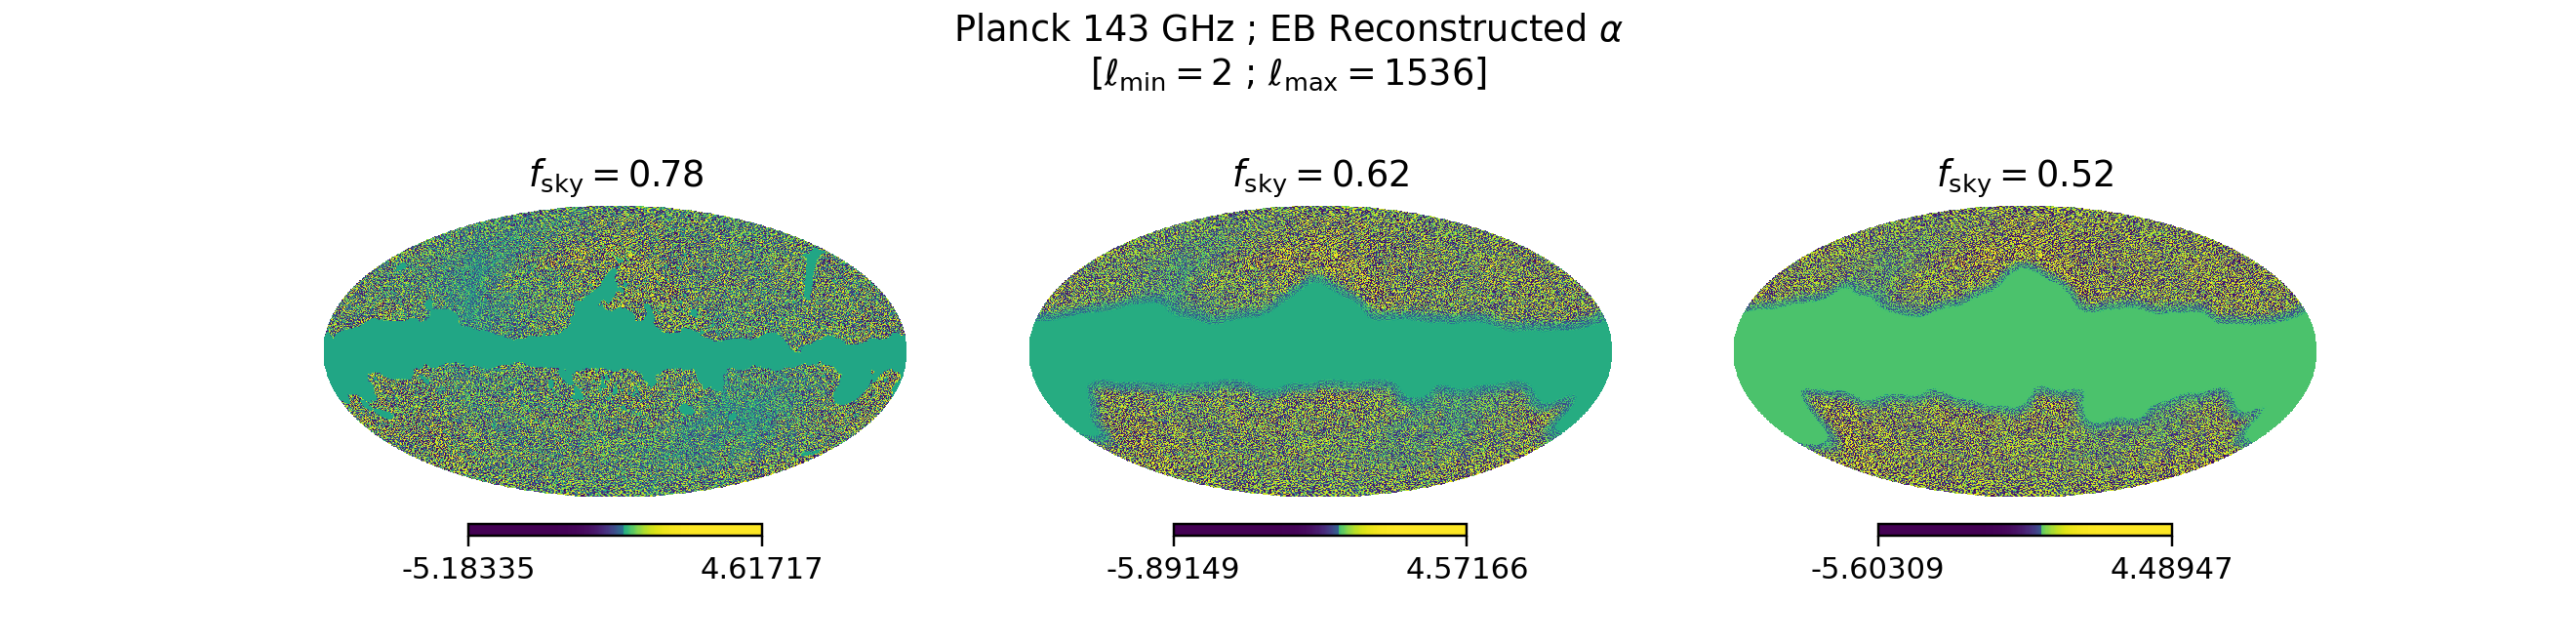

/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This

In [155]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3,figsize=[12,3.])
axes(ax1)
h.mollview(eb78.rec_alpha*mask78,hold=True,title=r"$f_{\rm sky}=$" + str(round(fsky78,2)),norm="hist")
# h.mollview(eb72.rec_alpha*mask72,hold=True,title=r"$f_{\rm sky}=$" + str(round(fsky72,2)),norm="hist")
axes(ax2)
h.mollview(eb62.rec_alpha*mask62,hold=True,title=r"$f_{\rm sky}=$" + str(round(fsky62,2)),norm="hist")
axes(ax3)
h.mollview(eb52.rec_alpha*mask52,hold=True,title=r"$f_{\rm sky}=$" + str(round(fsky52,2)),norm="hist")
suptitle(r"Planck 143 GHz ; EB Reconstructed $\alpha$" "\n" r"[$\ell_{\rm min}=$" + str(lmin) + " ; " + r"$\ell_{\rm max}=$"  + str(lmax) + "]")
figname=figpath + "planck143_eb_reconstructed_alpha_lmin" + str(lmin) + "_lmax" + str(lmax) + "_Lmax" + str(Lmax) + ".pdf"
savefig(figname,bbox_inches="tight",dpi=300)

<IPython.core.display.Javascript object>


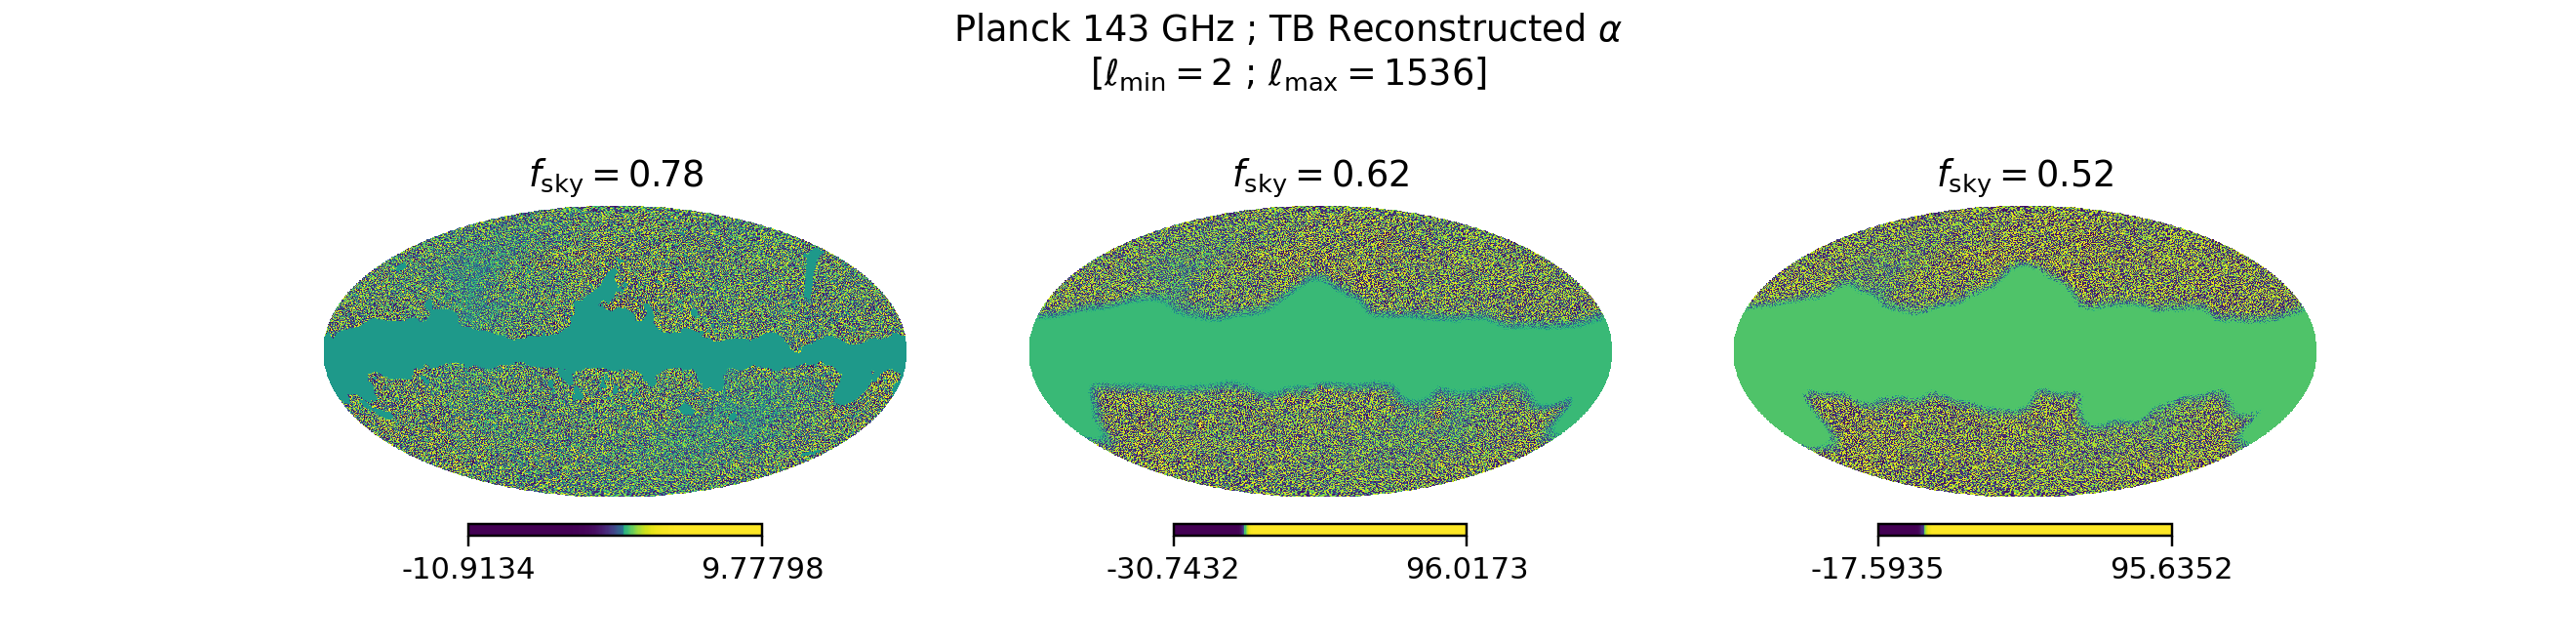

/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This

In [156]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3,figsize=[12,3.])
axes(ax1)
# h.mollview(tb72.rec_alpha*mask72,hold=True,title=r"$f_{\rm sky}=$" + str(round(fsky72,2)),norm="hist")
h.mollview(tb78.rec_alpha*mask78,hold=True,title=r"$f_{\rm sky}=$" + str(round(fsky78,2)),norm="hist")
axes(ax2)
h.mollview(tb62.rec_alpha*mask62,hold=True,title=r"$f_{\rm sky}=$" + str(round(fsky62,2)),norm="hist")
axes(ax3)
h.mollview(tb52.rec_alpha*mask52,hold=True,title=r"$f_{\rm sky}=$" + str(round(fsky52,2)),norm="hist")
suptitle(r"Planck 143 GHz ; TB Reconstructed $\alpha$" "\n" r"[$\ell_{\rm min}=$" + str(lmin) + " ; " + r"$\ell_{\rm max}=$"  + str(lmax) + "]")
figname=figpath + "planck143_tb_reconstructed_alpha_lmin" + str(lmin) + "_lmax" + str(lmax) + "_Lmax" + str(Lmax) + ".pdf"
savefig(figname,bbox_inches="tight",dpi=300)

In [157]:
file_suffix="_143GHz" + "_lmax" + str(lmax) + "_Lmax" + str(Lmax) 
filename=datapath + "fsky78_NL" + file_suffix + ".txt"
print(filename)
np.savetxt(filename , eb78.N_L)
filename=datapath + "fsky78_CL" + file_suffix + ".txt"
np.savetxt(filename , eb78.Cl_rec_alpha)
filename=datapath + "fsky78_rec_alpha" + file_suffix + ".fits"
h.write_map(filename,eb78.rec_alpha)

./planck143_rerun//data_143/fsky78_NL_143GHz_lmax1536_Lmax512.txt


/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/fitsfunc.py:200: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning,


# Birefringence constraints

In [1]:
clthry=np.zeros(Lmax+1,np.float64)
clthry[1:]=2.*pi/(L[1:]*(L[1:]+1))

NameError: name 'np' is not defined

In [201]:
def bire_lkl(A,Clobs,Nl,clthry,fsky,Lmax):
    L=np.arange(Lmax+1)
    var=(2./((2.*L+1)*fsky))*Nl[:Lmax+1]**2.
    chi2=np.sum((Clobs[1:Lmax]-Nl[1:Lmax]-A*clthry[1:Lmax])**2/var[1:Lmax])
    return chi2

In [202]:
Avals=np.logspace(-6,-3,1000)
chi_eb52=np.zeros_like(Avals)
chi_eb62=np.zeros_like(Avals)
chi_eb72=np.zeros_like(Avals)
chi_tb52=np.zeros_like(Avals)
chi_tb62=np.zeros_like(Avals)
chi_tb72=np.zeros_like(Avals)
Lmax=32
for i,A in enumerate(Avals):
    chi_eb52[i]=bire_lkl(A,eb52.Cl_rec_alpha,eb52.N_L,clthry,eb52.fsky,Lmax)
    chi_eb62[i]=bire_lkl(A,eb62.Cl_rec_alpha,eb62.N_L,clthry,eb62.fsky,Lmax)
    chi_eb72[i]=bire_lkl(A,eb72.Cl_rec_alpha,eb72.N_L,clthry,eb72.fsky,Lmax)
    chi_tb52[i]=bire_lkl(A,tb52.Cl_rec_alpha,tb52.N_L,clthry,tb52.fsky,Lmax)
    chi_tb62[i]=bire_lkl(A,tb62.Cl_rec_alpha,tb62.N_L,clthry,tb62.fsky,Lmax)
    chi_tb72[i]=bire_lkl(A,tb72.Cl_rec_alpha,tb72.N_L,clthry,tb72.fsky,Lmax)

In [203]:
chi_eb52=chi_eb52/min(chi_eb52)
chi_eb62=chi_eb62/min(chi_eb62)
chi_eb72=chi_eb72/min(chi_eb72)

chi_tb52=chi_tb52/min(chi_tb52)
chi_tb62=chi_tb62/min(chi_tb62)
chi_tb72=chi_tb72/min(chi_tb72)

<IPython.core.display.Javascript object>


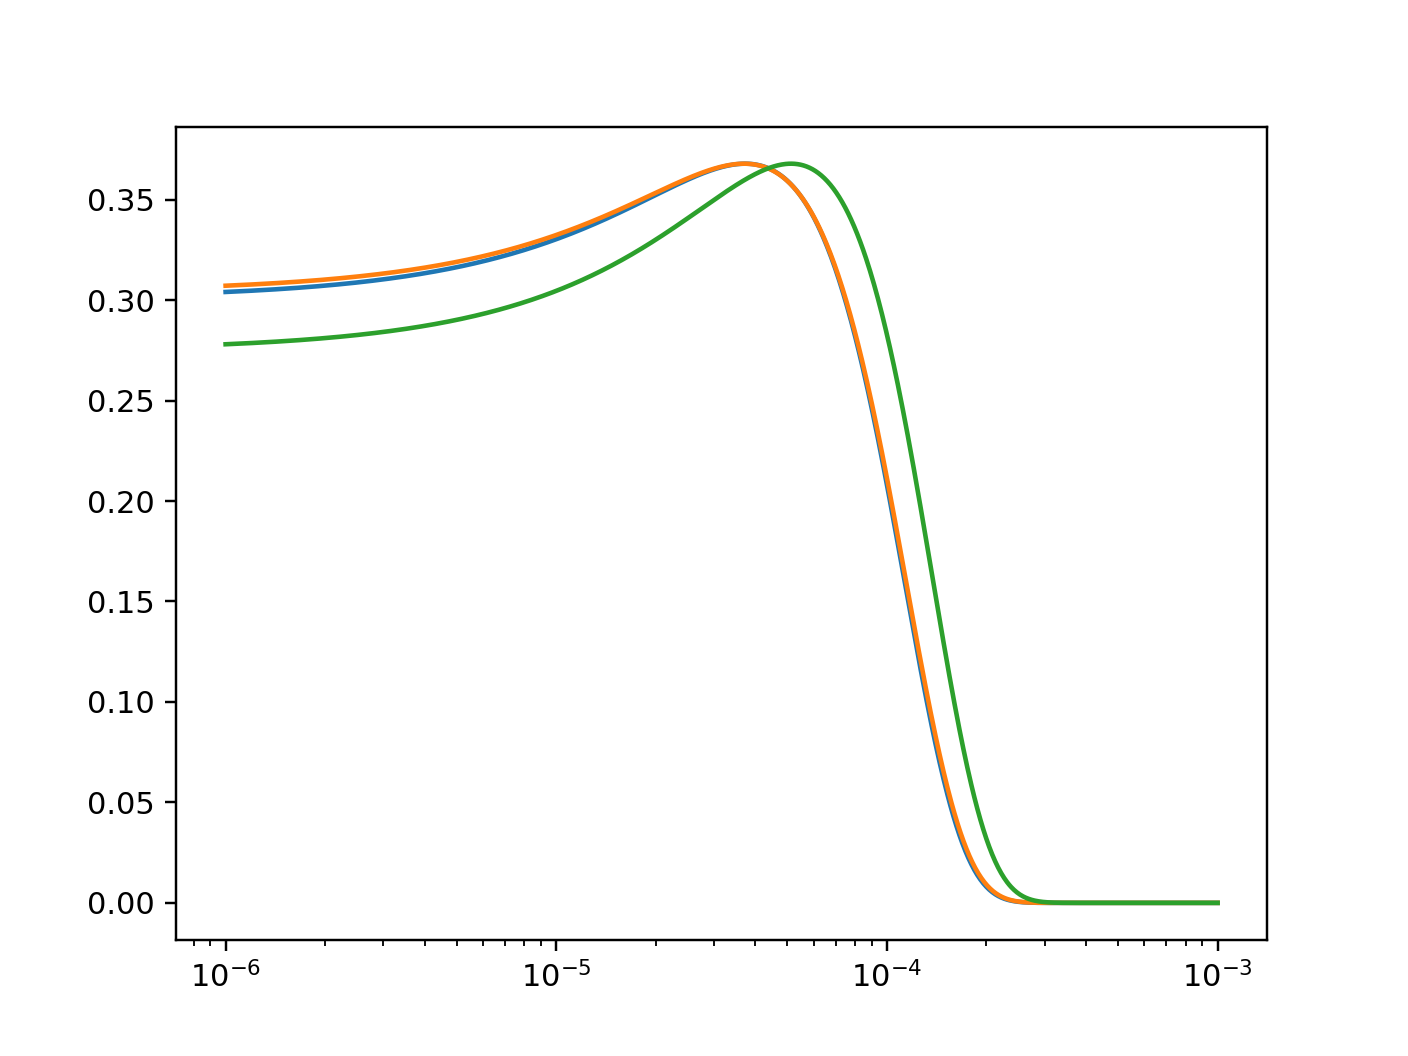

<IPython.core.display.Javascript object>


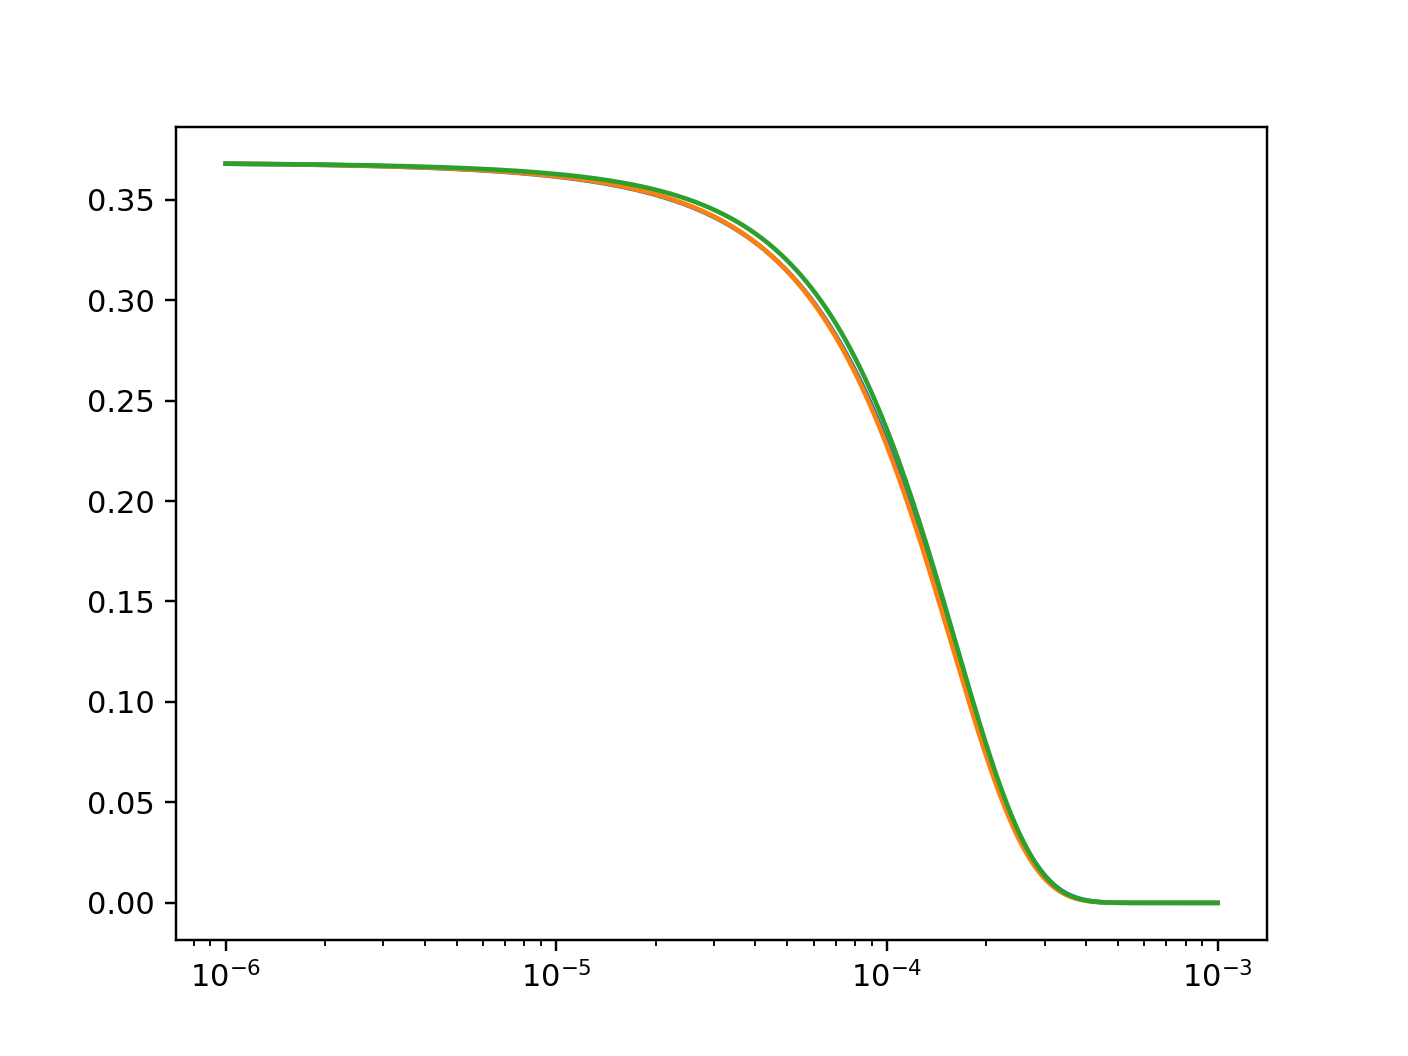

[]

In [204]:
figure()
plot(Avals,exp(-chi_eb52))
plot(Avals,exp(-chi_eb62))
plot(Avals,exp(-chi_eb72))
semilogx()

figure()
plot(Avals,exp(-chi_tb52))
plot(Avals,exp(-chi_tb62))
plot(Avals,exp(-chi_tb72))
semilogx()

<IPython.core.display.Javascript object>


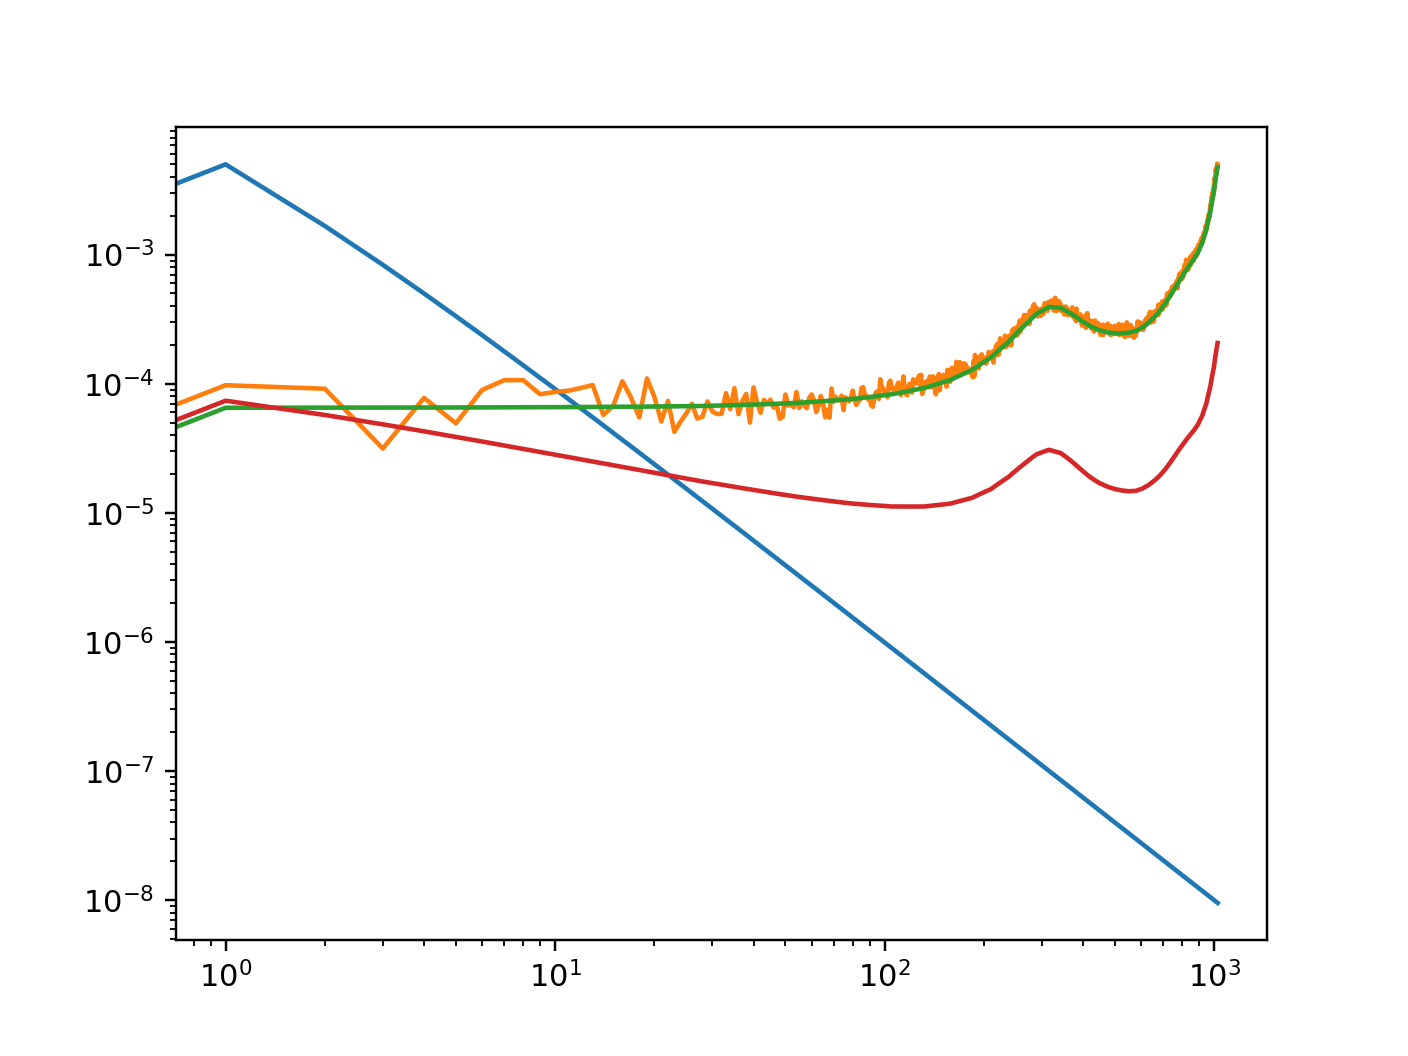

<IPython.core.display.Javascript object>


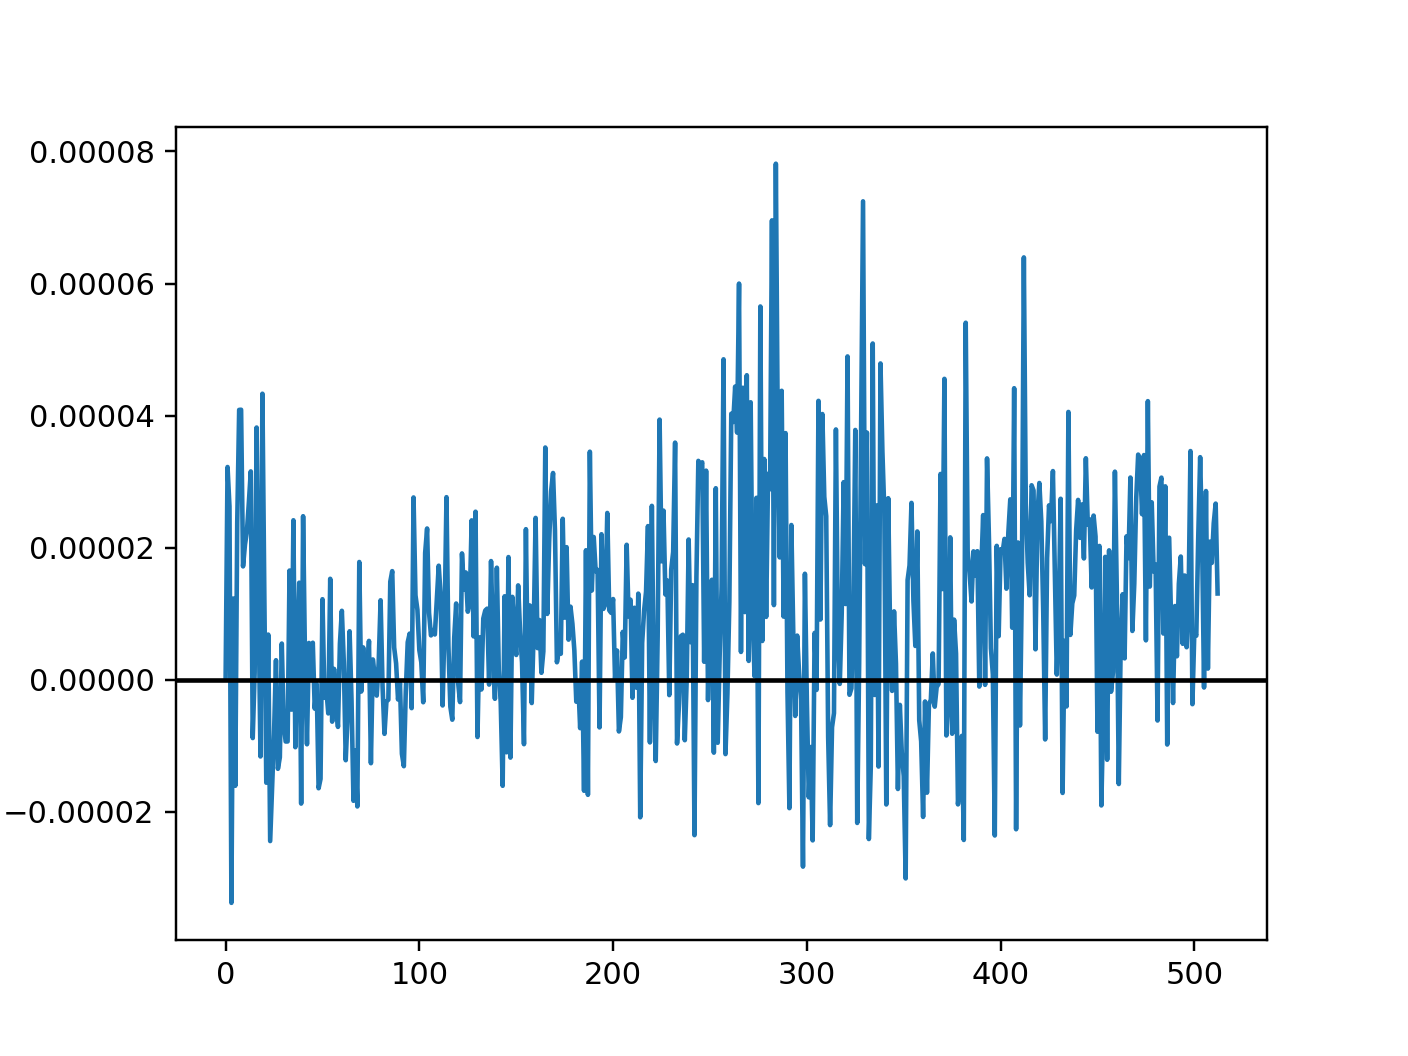

In [257]:
figure()
plot(cl_alpha*1e-2)
plot(eb52.Cl_rec_alpha)
plot(eb52.N_L)
plot(eb52.N_L*np.sqrt(2./((2.*L+1)*eb52.fsky)))
loglog()

figure()
plot(eb52.Cl_rec_alpha[:513]-eb52.N_L[:513])
axhline(0,color="k")